In [11]:
%%bash
data = cd ../../../datag/blpd0/datax/Voyager_data
ls

bash: line 1: data: command not found


blimpy_voyager.ipynb
test.png


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate
from astropy.time import Time
from tqdm import tqdm
import csv

In [3]:
def set_filter(file, start, stop, drift_max=0, snr_max=50, beam_val=2 ):
    # Load and slice dataset
    global df_new
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]

    # Select relevant columns
    columns = ['file_uri', 'observation_id','source_name', 'beam_id', 'ra_hours', 'dec_degrees', 'tstart',
               'signal_frequency', 'signal_beam', 'signal_drift_rate', 'signal_snr',
               'signal_power', 'signal_incoherent_power']
    df_new = small_df[columns]

    # Apply filtering thresholds
    df_new = df_new[(df_new['signal_drift_rate'] != drift_max) &
                    (df_new['signal_snr'] <= snr_max) &
                    (df_new['signal_beam'] <= beam_val)]
    
    #print(f"Total filtered hits: {len(df_new)}")

    return df_new



In [4]:
#rfi filtering based on power ratio and overlapping frequency in fov 
def processing(file, start, stop):
    df_new = set_filter(file, start, stop)
    fov_group = df_new.groupby('file_uri')
    all_fov_dfs = []

    for file_uri, fov_df in fov_group:
        fov_df = fov_df.copy()  # avoid SettingWithCopyWarning
        fov_df['rfi_flag'] = False  # initialize all False

        

        # Flag overlapping frequencies at same tstart
        grouped_time = fov_df.groupby('tstart')
        overlap_indices = []
        for t_value, t_df in grouped_time:
            freq_counts = t_df['signal_frequency'].value_counts()
            overlapping_freqs = freq_counts[freq_counts > 1]
            for freq in overlapping_freqs.index:
                hits = t_df[t_df['signal_frequency'] == freq]
                overlap_indices.extend(hits.index.tolist())

        # Set rfi_flag True for overlapping hits
        fov_df.loc[overlap_indices, 'rfi_flag'] = True

        # Power ratio flagging of entire FOV if condition met
        for idx, row in fov_df.iterrows():
            incoh = row['signal_incoherent_power']
            coh = row['signal_power']
            if incoh > 0 and (coh / incoh) > 2.5:

                fov_df.at[idx, 'rfi_flag'] = True  # Flag only this hit

        all_fov_dfs.append(fov_df)
    full_df = pd.concat(all_fov_dfs, ignore_index=True)
    #print(full_df.groupby('rfi_flag').size())

    return full_df

#processing('Summer_Project_RA9_Dec0.90.pkl', 0, 1000000)


In [5]:
full_df = processing('Summer_Project_RA9_Dec0.90.pkl', 0, 1000000)


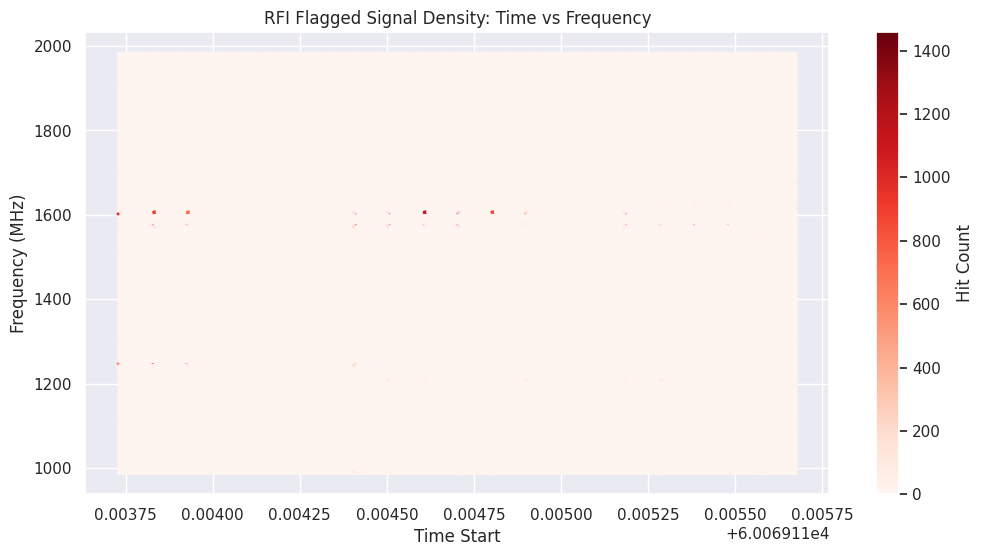

In [ ]:
# signal density/ timevs freq
rfi_only = full_df[full_df['rfi_flag']]
plt.figure(figsize=(12, 6))
plt.hexbin(rfi_only['tstart'], rfi_only['signal_frequency'], gridsize=200, cmap='Reds')
plt.xlabel("Time Start")
plt.ylabel("Frequency (MHz)")
plt.title("RFI Flagged Signal Density: Time vs Frequency")
plt.colorbar(label='Hit Count')
plt.show()

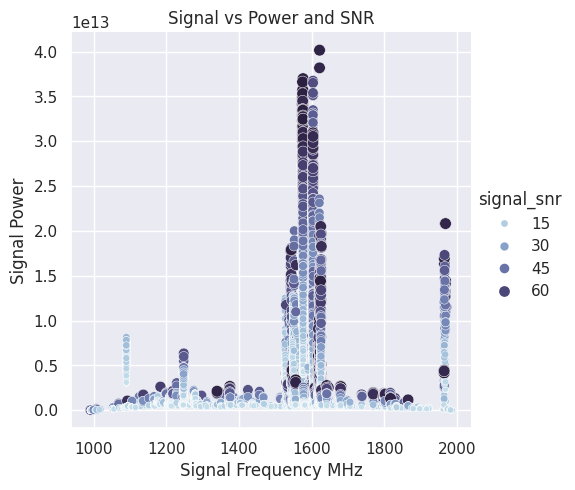

In [10]:
#visualize signal vs power with snr value incuded 
def pow_freq_snr(full_df):
    df_new = full_df
    sns.set_theme()
    sns.relplot(data=df_new, x=df_new["signal_frequency"], y=df_new["signal_power"], 
                hue=df_new["signal_snr"], size = df_new["signal_snr"], palette = "ch:s=.25,rot=-.25")
 
    plt.xlabel("Signal Frequency MHz")
    plt.ylabel("Signal Power")
    plt.title("Signal vs Power and SNR")
    plt.grid(True)
    plt.show()

pow_freq_snr(full_df)

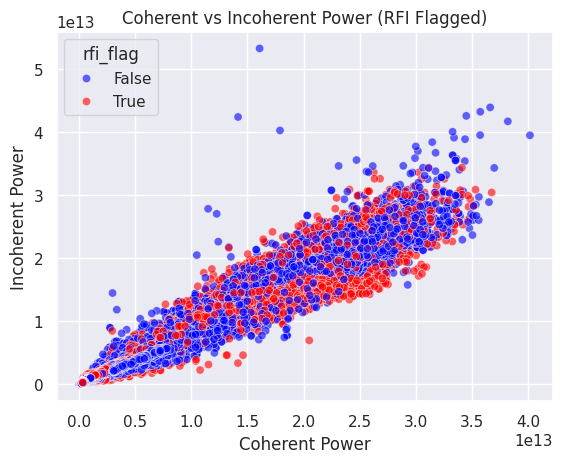

In [11]:
#visualize incoh to coh power with rfi flags included 
def pow_incoh_coh(full_df):
    df_new = full_df
    
    sns.scatterplot(
        data=df_new,
        x='signal_power',  # coherent
        y='signal_incoherent_power',
        hue='rfi_flag',
        palette={False: 'blue', True: 'red'},
        alpha=0.6
    )
    plt.xlabel("Coherent Power")
    plt.ylabel("Incoherent Power")
    plt.title("Coherent vs Incoherent Power (RFI Flagged)")
    plt.grid(True)
    plt.show()

pow_incoh_coh(full_df)

Excess Kurtosis: 3.372326971058685
Skewness: 1.1274314091766342


/tmp/ipykernel_3654602/1143294128.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)


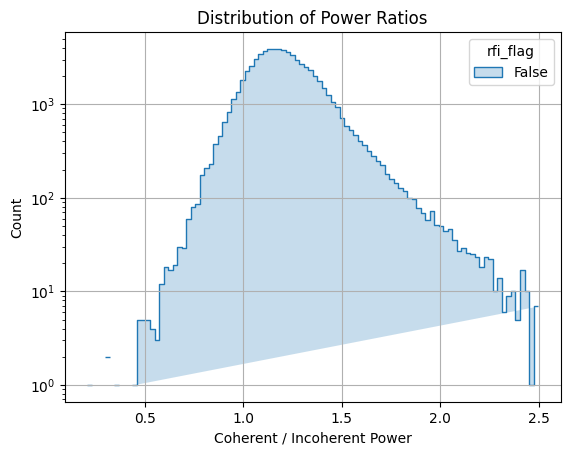

In [6]:
# visualize distribution of power ratios across data set/ time 
from scipy.stats import kurtosis, skew
non_rfi_df = full_df[full_df['rfi_flag'] == False]
ratios = non_rfi_df['signal_power'] / non_rfi_df['signal_incoherent_power']
ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()
print("Excess Kurtosis:", kurtosis(ratios, fisher=True))  # >0 = heavy tail
print("Skewness:", skew(ratios))

non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)
sns.histplot(data=non_rfi_df, x='power_ratio', hue='rfi_flag', bins=100, log_scale=(False, True), element='step')  
plt.title("Distribution of Power Ratios")
plt.xlabel("Coherent / Incoherent Power")
plt.grid(True)
plt.show()

non_rfi_df.to_pickle('data/non_rfi_df.pkl')

#save in pickle file in scratch space 

In [ ]:
def processing(file,start,stop):
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]
    columns=['source_name','beam_id','ra_hours' , 'dec_degrees' , 'tstart','signal_frequency', 'signal_beam', 
             'signal_drift_rate', 'signal_snr' , 'signal_power' , 'signal_incoherent_power']
    df_new= small_df[columns]
    #signal_drift_rate == 0 remove
    # S/R > 20 remove 
    grouped_dec = df_new.groupby("dec_degrees")

    dec_dfs={}
    for dec_value, group_df in grouped_dec:
        dec_dfs[dec_value] = group_df  # Save entire group DataFrame
        #print(len(group_df))
       # print(group_df.groupby("ra_hours").size())

    for i, (dec_value, df) in enumerate(dec_dfs.items(), start=1):
        globals()[f"fov_{i}"] = df
    print(len(fov_1))
    print(fov_1.groupby("tstart").size())

    return fov_1.head()
   # print(len(np.unique(df_new['signal_frequency'])))
   # print(df_new.groupby("tstart").size())
   # print(df_new.groupby("ra_hours").size())
   # print(df_new.groupby("signal_frequency").size())


    #return df_new

    

processing('Summer_Project_RA9_Dec0.90.pkl', 0,1000000)


167716
tstart
60069.113731     2230
60069.113829     3740
60069.113926     4634
60069.114411    15698
60069.114508    15110
60069.114605    15737
60069.114702    15544
60069.114799    10009
60069.114897    10796
60069.114994      436
60069.115091      186
60069.115188    14466
60069.115285    13646
60069.115382    13158
60069.115479    12895
60069.115576    11227
60069.115673     8204
dtype: int64


,source_name,beam_id,ra_hours,dec_degrees,tstart,signal_frequency,signal_beam,signal_drift_rate,signal_snr,signal_power,signal_incoherent_power
3,743517082989416704,32100,9.939133,28.7294,60069.113926,1990.883732,3,0.0,10.802960,1.297620e+10,1.243778e+10
22,743517082989416704,32100,9.939133,28.7294,60069.113926,1993.136731,3,0.0,13.276069,1.221296e+10,1.136826e+10
241,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.756985,3,0.0,16.291704,1.014853e+12,9.275462e+11
243,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.697094,3,0.0,9.456708,6.825698e+11,6.960990e+11
245,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.713986,3,0.0,11.549982,7.843343e+11,6.280134e+11


In [6]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    uniqude_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    
    plt.tight_layout()


In [ ]:
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



%matplotlib inline
plt.figure(figsize=(10,6))
non_rfi_df = full_df[full_df['rfi_flag'] == False]
# 1. Prepare full-dimensional numeric data
X = non_rfi_df.select_dtypes(include=[np.number]).fillna(0).values
print(X.shape)

# 2. Fit HDBSCAN
clusterer = HDBSCAN(min_cluster_size=10, n_jobs=-1)
clusterer.fit(X)
labels = clusterer.labels_
probabilities = getattr(clusterer, "probabilities_", None)
print(np.count_nonzero(np.where(labels==-1)))

# 3. Project to 2D for visualization
X_2d = PCA(n_components=2).fit_transform(X)

# 4. Plot clusters
plot(X_2d, labels, probabilities=probabilities, parameters={"min_cluster_size":10})
plt.show()


(69705, 11)
